In [41]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation

from qclib.machine_learning.datasets import digits

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.compression import SchmidtCompressor

In [42]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [0,1], [1,8], [2,4,7], etc.
# At least two classes must be chosen.
sample_total, training_input, test_input, class_labels = digits.load(classes=[0,1],
                                                                     training_size=160,
                                                                     test_size=10,
                                                                     random_seed=seed)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[]]
figures = [[],[]]

In [43]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(160, 64)
(160, 64)
(10, 64)
(10, 64)


In [44]:
# Utility functions.
def calc_fidelity(state1, state2):
    bra = np.conj(state1)
    ket = state2

    return np.power(np.abs(bra.dot(ket)), 2)

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10*matrix_dim_1/_dpi, 10*matrix_dim_2/_dpi), dpi=_dpi)
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

***
## Calculates the typical state
***

In [45]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    centroid += train_sample

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


***
## Creates de compressor
***

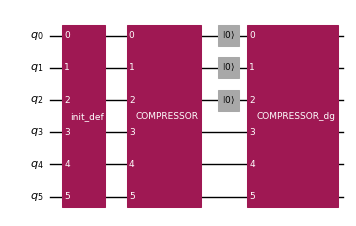

In [46]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
channel = [3,4,5]

partition = list(set(range(n_qubits)).difference(
    set([n_qubits-i-1 for i in channel])
))

compressor = SchmidtCompressor(typical_state, opt_params={'partition': partition, 'lr': 0})
decompressor = compressor.inverse()

# Draw an example of the circuit.
initializer = StatePreparation(typical_state)

circuit = QuantumCircuit(n_qubits)
circuit.append(initializer.definition, range(n_qubits))
circuit.append(compressor.definition, range(n_qubits))
circuit.reset(compressor.trash_qubits)
circuit.append(decompressor.definition, range(n_qubits))

circuit.draw('mpl', scale=0.5, style="iqp")

In [47]:
from qclib.util import get_cnot_count
print(get_cnot_count(compressor.definition))

43


***
## Main experiment
***
Using |0> as the reference state.

0 - Recovered state fidelity = 0.9205221343622271


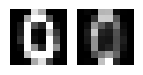

1 - Recovered state fidelity = 0.810112434364102


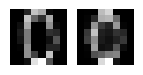

2 - Recovered state fidelity = 0.916705777360894


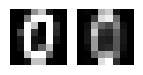

3 - Recovered state fidelity = 0.8707497611790468


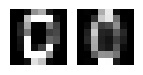

4 - Recovered state fidelity = 0.7489445921175802


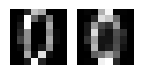

5 - Recovered state fidelity = 0.8409808824543301


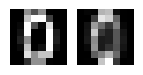

6 - Recovered state fidelity = 0.8765367123901708


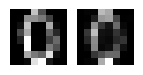

7 - Recovered state fidelity = 0.7817234146998625


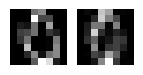

8 - Recovered state fidelity = 0.7853216388614361


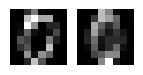

9 - Recovered state fidelity = 0.8141954557217153


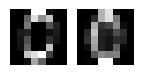

10 - Recovered state fidelity = 0.6751952411300443


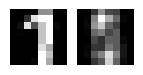

11 - Recovered state fidelity = 0.7375150544553863


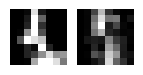

12 - Recovered state fidelity = 0.5208767211617332


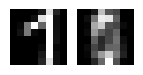

13 - Recovered state fidelity = 0.7099670371186231


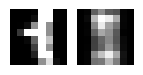

14 - Recovered state fidelity = 0.7000503563796698


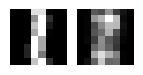

15 - Recovered state fidelity = 0.6852100610981293


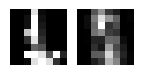

16 - Recovered state fidelity = 0.641858762046758


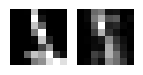

17 - Recovered state fidelity = 0.82288963570337


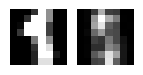

18 - Recovered state fidelity = 0.8341165928395756


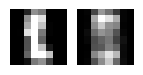

19 - Recovered state fidelity = 0.557789127794584


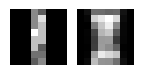

In [48]:
from qiskit.quantum_info import Statevector

fidelities[0].clear()
figures[0].clear()

# Applies the compression-decompression process to each of the test samples.

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    circuit.reset(compressor.trash_qubits)
    circuit.append(decompressor.definition, range(n_qubits))

    # There is a sporadic bug in the reset.
    # For now, I've decided to run the same piece of code five
    # times to avoid it, but at some point it will be necessary
    # to investigate the problem.
    output_probs = None
    fidelity = 0.0
    for _ in range(10):
        _output_state = Statevector(circuit).data
        _fidelity = calc_fidelity(test_sample, _output_state)
        if _fidelity > fidelity:
            fidelity = _fidelity
            output_probs = np.abs(_output_state)**2

    fidelities[0].append(fidelity)
    figures[0].append([np.abs(test_sample)**2, output_probs])
    print(i, '- Recovered state fidelity =', fidelity)
    plot_digits([np.abs(test_sample)**2, output_probs], n_qubits)

***
## Optimization
***
This optimization is based on the conservation of entropy.
As we are dealing with a pure state (Alice's side), our goal is to produce an initial state of zero entropy (or close to zero) on Bob's side.

In [49]:
# Calculates one average trash state density matrix.
from qiskit.quantum_info import Statevector, partial_trace

# Applies the compression process to each of the train samples
# and calculates the correspondent trash state.

for i, train_sample in enumerate(np.concatenate([train_samples for _, train_samples in training_input.items()])):
    initializer = StatePreparation(train_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), compressor.latent_qubits)
    
    break

### Creates an example of the reference state initializer

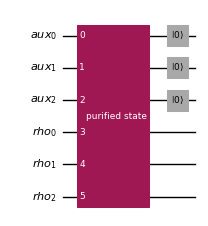

In [50]:
import numpy as np
from qclib.state_preparation import MixedInitialize
# Creates the reference state initializer based on the average trash state.
reference_initializer = MixedInitialize(trash_state.data.T, classical=True, reset=True)

reference_initializer.definition.draw('mpl', scale=0.5, style="iqp")

### Draws an example of the complete circuit

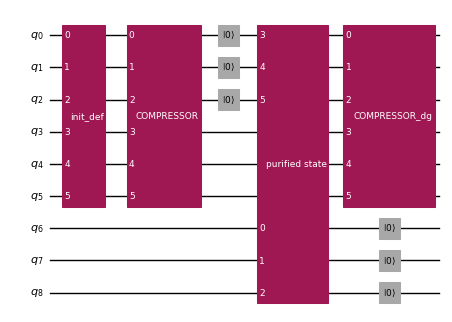

In [51]:
# Draw an example of the circuit.
initializer = StatePreparation(typical_state)

n_aux_qubits = reference_initializer.num_qubits - len(compressor.trash_qubits)
aux_qubits = list(range(n_qubits, n_qubits+n_aux_qubits))

circuit = QuantumCircuit(n_qubits + n_aux_qubits)
circuit.append(initializer.definition, range(n_qubits))
circuit.append(compressor.definition, range(n_qubits))
circuit.reset(compressor.trash_qubits)
circuit.compose(
    reference_initializer.definition,
    aux_qubits + compressor.trash_qubits,
    inplace=True
)
circuit.append(decompressor.definition, range(n_qubits))

circuit.draw('mpl', scale=0.5, style="iqp")

## Optimized experiment:
Uses the exact trash state as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution.

0 - Recovered state fidelity = 0.9466591233218239


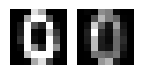

1 - Recovered state fidelity = 0.8379940232171736


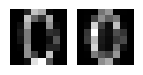

2 - Recovered state fidelity = 0.9440010098214429


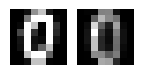

3 - Recovered state fidelity = 0.8895636331899871


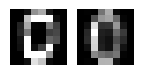

4 - Recovered state fidelity = 0.8339473707978474


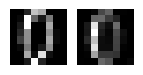

5 - Recovered state fidelity = 0.9012687449104158


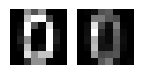

6 - Recovered state fidelity = 0.9079355642399348


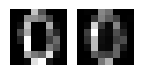

7 - Recovered state fidelity = 0.847844404550011


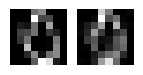

8 - Recovered state fidelity = 0.8306131773475278


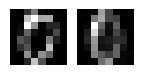

9 - Recovered state fidelity = 0.8189982142638467


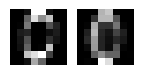

10 - Recovered state fidelity = 0.8892322642605515


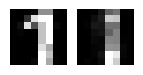

11 - Recovered state fidelity = 0.8044419073682754


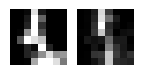

12 - Recovered state fidelity = 0.8178479413523151


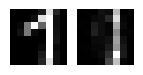

13 - Recovered state fidelity = 0.8795580682016574


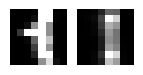

14 - Recovered state fidelity = 0.9501786612434188


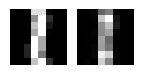

15 - Recovered state fidelity = 0.7901034142143109


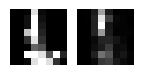

16 - Recovered state fidelity = 0.7738211738480822


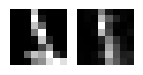

17 - Recovered state fidelity = 0.8987623057797335


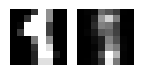

18 - Recovered state fidelity = 0.9347369207565205


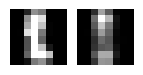

19 - Recovered state fidelity = 0.9727609109411081


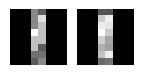

In [52]:
from qiskit.quantum_info import Statevector, partial_trace

aux_zero = [1] + [0] * (2**n_aux_qubits-1)

fidelities[1].clear()
figures[1].clear()

# Applies the compression-decompression process to each of the test samples.

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits + n_aux_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), aux_qubits + compressor.latent_qubits)
    trash_initializer = MixedInitialize(trash_state.data.T, classical=True, reset=True)
    
    circuit.reset(compressor.trash_qubits)
    circuit.compose(
        trash_initializer.definition,
        aux_qubits + compressor.trash_qubits,
        inplace=True
    )
    circuit.append(decompressor.definition, range(n_qubits))

    # There is a sporadic bug in the reset.
    # For now, I've decided to run the same piece of code five
    # times to avoid it, but at some point it will be necessary
    # to investigate the problem.
    output_probs = None
    fidelity = 0.0
    for _ in range(10):
        state_vector = Statevector(circuit)
        _output_state = state_vector.data
        _fidelity = calc_fidelity(np.kron(aux_zero, test_sample), _output_state)
        if _fidelity > fidelity:
            fidelity = _fidelity
            output_probs = _output_state = state_vector.probabilities(range(n_qubits))

    fidelities[1].append(fidelity)
    figures[1].append([output_probs])
    print(i, '- Recovered state fidelity =', fidelity)
    plot_digits([np.abs(test_sample)**2, output_probs], n_qubits)

***
## Summary
***

In [53]:
for i, (item1, item2) in enumerate(zip(fidelities[0],fidelities[1])):
    print(i, '-', item1, item2)

0 - 0.9205221343622271 0.9466591233218239
1 - 0.810112434364102 0.8379940232171736
2 - 0.916705777360894 0.9440010098214429
3 - 0.8707497611790468 0.8895636331899871
4 - 0.7489445921175802 0.8339473707978474
5 - 0.8409808824543301 0.9012687449104158
6 - 0.8765367123901708 0.9079355642399348
7 - 0.7817234146998625 0.847844404550011
8 - 0.7853216388614361 0.8306131773475278
9 - 0.8141954557217153 0.8189982142638467
10 - 0.6751952411300443 0.8892322642605515
11 - 0.7375150544553863 0.8044419073682754
12 - 0.5208767211617332 0.8178479413523151
13 - 0.7099670371186231 0.8795580682016574
14 - 0.7000503563796698 0.9501786612434188
15 - 0.6852100610981293 0.7901034142143109
16 - 0.641858762046758 0.7738211738480822
17 - 0.82288963570337 0.8987623057797335
18 - 0.8341165928395756 0.9347369207565205
19 - 0.557789127794584 0.9727609109411081


0


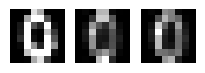

1


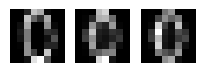

2


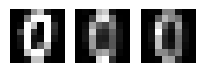

3


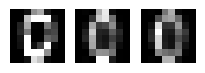

4


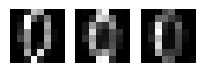

5


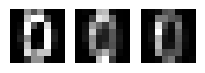

6


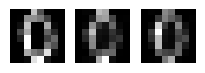

7


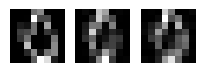

8


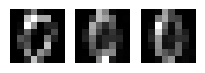

9


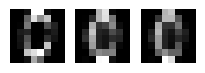

10


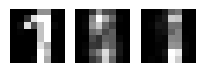

11


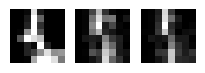

12


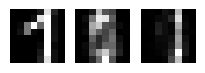

13


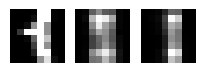

14


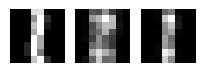

15


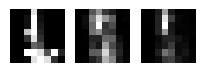

16


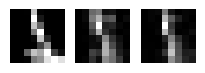

17


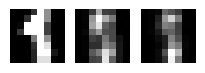

18


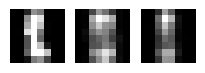

19


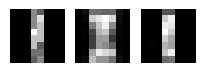

In [54]:
for i, (item1, item2) in enumerate(zip(figures[0],figures[1])):
    print(i)
    plot_digits([item1[0], item1[1], item2[0]], n_qubits)